# Progress


Options

1. Use relaxed dominance to reduce the number of nds solutions in the grid (and, hopefully, reduce the number of DRS)
2. Analyze why IPBI reached a better DCI, even when `dci_norm` was employed


## Codigo

In [1]:
import numpy as np
import os, sys

rocket_path = "/home/auraham/improved_mss"
sys.path.insert(0, rocket_path)

from rocket.plot import load_rcparams, plot_pops

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
from mpl_toolkits.mplot3d import Axes3D

np.seterr(all='raise')

from vfns import vfns
from dci import get_grid_dims, dci_norm, dci_norm_cedas

def load_objs(fev):
    
    moea_name = "amoead_mss_v4-no-form-contrib_step-25-contrib_window-10-smooth-mean-contrib-fast_no_parent_sdci2-assignment-fast"
    filename = "objs_%s_m_3_run_0_t_25_fev_%s.txt" % (moea_name, fev)
    filepath = os.path.join("sample_pops", "inv-dtlz1", moea_name, "pops", filename)
    
    objs = np.genfromtxt(filepath)
    
    return objs.copy()
    
def vector_str(v):
    
    line = " ".join(["%.10f" % val for val in v])
    return line

## 1. Handling dominance resistance solutions

In [3]:
# load objs
objs_a = load_objs("ipbi-2")
objs_b = load_objs("ipbi-4")
objs_c = load_objs("ipbi-5")
objs_d = load_objs("ipbi-6")
objs_e = load_objs("ipbi-8")
objs_f = load_objs("pbi-5")

# make a list of pops
pops = (objs_a, objs_b, objs_c, objs_d, objs_e, objs_f)
labels = ("ipbi-2", "ipbi-4", "ipbi-5", "ipbi-6", "ipbi-8", "pbi-5")

# get non-dominated solutions using vfns
merged_pops = np.vstack(pops)
fronts, ranks = vfns(merged_pops, procs=4)
best_front = np.array(fronts[0], dtype=int)
objs_nds = merged_pops[best_front]

# get reference vectors from non-dominated solutions
z_ideal = objs_nds.min(axis=0)
z_nadir = objs_nds.max(axis=0)

# print vectors
print("z_ideal:", vector_str(z_ideal))
print("z_nadir:", vector_str(z_nadir))

# compute dci
divs = 19
dci_vals = dci_norm(pops, divs, procs=4, debug=True)

# print results
for i, val in enumerate(dci_vals):

    pop_label = labels[i]
    print("DCI(%s) \t= %.4f" % (pop_label, val))


z_ideal: 1.0906578799 2.1118154386 1.0546457250
z_nadir: 334.0560817797 334.6945123332 87.6318007555
The number of non-dominated solutions is 18
lb: 0.00000000 0.00000000 0.00000000
ub: 1.02631579 1.02631579 1.02631579
hs: 0.05401662 0.05401662 0.05401662
pop 0 has 43 in the grid (original size: 91)
pop 1 has 40 in the grid (original size: 91)
pop 2 has 45 in the grid (original size: 91)
pop 3 has 49 in the grid (original size: 91)
pop 4 has 42 in the grid (original size: 91)
pop 5 has 91 in the grid (original size: 91)
This pop has 18 in the grid (original size: 18)
The number of boxes where all solutions locate is 3
DCI(ipbi-2) 	= 0.6667
DCI(ipbi-4) 	= 0.6667
DCI(ipbi-5) 	= 1.0000
DCI(ipbi-6) 	= 0.9167
DCI(ipbi-8) 	= 0.6667
DCI(pbi-5) 	= 0.3333


Como se puede ver, el valor de DCI de ipbi-5 es el mejor, pero deberia ser pbi5. Para entender mejor qué está pasando, vamos a crear una copia de `dci_norm`y a modificarla en el notebook:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import os, sys
from vfns import vfns
from dci import normalize_pops, normalize, filter_pop, filter_pops, get_grid_locs, get_grid_dims, get_contribution_degree

def dci_norm_debug(pops, divs, procs=4, debug=False):
    """
    Compute the DCI indicator using normalization.
    
    Input
    pops        list of (pop_size, m_objs) objs matrices
    divs        int, number of divisions of the grid
    procs       int, number of processes for nds
    
    Output
    dci_vals    (n_pops, ) dci values
    """
    
    # 1. get non-dominated solutions
    merged_pops = np.vstack(pops)
    fronts, ranks = vfns(merged_pops, procs)
    best_front = np.array(fronts[0], dtype=int)
    objs_nds = merged_pops[best_front]
    
    # debug
    if debug:
        print("The number of non-dominated solutions is %d" % objs_nds.shape[0]);
    
    # 2. obtain z_ideal, z_nadir from objs_nds
    z_ideal = objs_nds.min(axis=0)
    z_nadir = objs_nds.max(axis=0)
    
    # 3. normalize pops and objs_nds
    norm_pops = normalize_pops(pops, z_ideal, z_nadir)
    norm_objs_nds = normalize(objs_nds, z_ideal, z_nadir)
    
    # 4. compute grid dimesions
    m_objs = norm_objs_nds.shape[1]
    ref_ideal = np.zeros((m_objs, ))
    ref_nadir = np.ones((m_objs, ))
    lb, ub, hs = get_grid_dims(ref_ideal, ref_nadir, divs)
    
    # debug
    if debug:
        print("lb: %s" % vector_str(lb))
        print("ub: %s" % vector_str(ub))
        print("hs: %s" % vector_str(hs))
    
    # remove solutions out of the grid
    pops = filter_pops(norm_pops, lb, ub, debug)
    objs_nds = filter_pop(norm_objs_nds, lb, ub, debug)
    
    # get locations of pops in grid
    locs_pops = []
    
    for objs_pop in pops:
        
        # (pop_size, m_objs) int matrix, it contains the location of
        # the obj vectors in objs_pop within the grid
        locs_pop = get_grid_locs(objs_pop, lb, hs)
        
        # add it to the list
        locs_pops.append(locs_pop.copy())
    
    # get nds location
    locs_nds = get_grid_locs(objs_nds, lb, hs)
    
    # get nds hyperboxes
    # we use a dictionary for efficient lookup and deletion of duplicate rows in locs_nds
    hyperboxes = {}
    
    for hb_loc in locs_nds:
        
        # cast from np.array to tuple
        key = tuple(hb_loc)
        
        if not key in hyperboxes:
            
            # hyperboxes[loc] contains the number of solutions in the
            # hyperbox defined by loc (although this counter is not necessary for computing DCI)
            hyperboxes[key] = 1         
        
        else:
            
            # increment counter
            hyperboxes[key] += 1
            
            
    
    # compute contribution degree
    n_pops = len(locs_pops)
    n_hyperboxes = len(hyperboxes)
    
    # debug
    if debug:
        print("The number of boxes where all solutions locate is %d" % n_hyperboxes);
    
    cd_matrix = np.zeros((n_hyperboxes, n_pops))
    
    for row, hyperbox in enumerate(hyperboxes):
        
        for col, locs_pop in enumerate(locs_pops):
            
            # compute contribution degree
            cd_matrix[row, col] = get_contribution_degree(locs_pop, hyperbox)
            
            # debug
            #if debug:
            #    print("CD(P[%d], h=%s): %.4f" % (col, hyperbox, cd_matrix[row, col]))
            
        # debug
        #if debug:
        #    print("---")
        
    # compute dci
    by_col = 0
    dci_vals = cd_matrix.sum(axis=by_col) / n_hyperboxes
    
    return dci_vals.copy(), pops, objs_nds

In [21]:
# load objs
objs_a = load_objs("ipbi-2")
objs_b = load_objs("ipbi-4")
objs_c = load_objs("ipbi-5")
objs_d = load_objs("ipbi-6")
objs_e = load_objs("ipbi-8")
objs_f = load_objs("pbi-5")

# make a list of pops
pops = (objs_a, objs_b, objs_c, objs_d, objs_e, objs_f)
labels = ("ipbi-2", "ipbi-4", "ipbi-5", "ipbi-6", "ipbi-8", "pbi-5")

# get non-dominated solutions using vfns
merged_pops = np.vstack(pops)
fronts, ranks = vfns(merged_pops, procs=4)
best_front = np.array(fronts[0], dtype=int)
objs_nds = merged_pops[best_front]

# get reference vectors from non-dominated solutions
z_ideal = objs_nds.min(axis=0)
z_nadir = objs_nds.max(axis=0)

# print vectors
print("z_ideal:", vector_str(z_ideal))
print("z_nadir:", vector_str(z_nadir))

# compute dci
divs = 19
dci_vals, new_pops, new_objs_nds = dci_norm_debug(pops, divs, procs=4, debug=True)

# print results
for i, val in enumerate(dci_vals):

    pop_label = labels[i]
    print("DCI(%s) \t= %.4f" % (pop_label, val))


z_ideal: 1.0906578799 2.1118154386 1.0546457250
z_nadir: 334.0560817797 334.6945123332 87.6318007555
The number of non-dominated solutions is 18
lb: 0.0000000000 0.0000000000 0.0000000000
ub: 1.0263157895 1.0263157895 1.0263157895
hs: 0.0540166205 0.0540166205 0.0540166205
pop 0 has 43 in the grid (original size: 91)
pop 1 has 40 in the grid (original size: 91)
pop 2 has 45 in the grid (original size: 91)
pop 3 has 49 in the grid (original size: 91)
pop 4 has 42 in the grid (original size: 91)
pop 5 has 91 in the grid (original size: 91)
This pop has 18 in the grid (original size: 18)
The number of boxes where all solutions locate is 3
DCI(ipbi-2) 	= 0.6667
DCI(ipbi-4) 	= 0.6667
DCI(ipbi-5) 	= 1.0000
DCI(ipbi-6) 	= 0.9167
DCI(ipbi-8) 	= 0.6667
DCI(pbi-5) 	= 0.3333


<IPython.core.display.Javascript object>


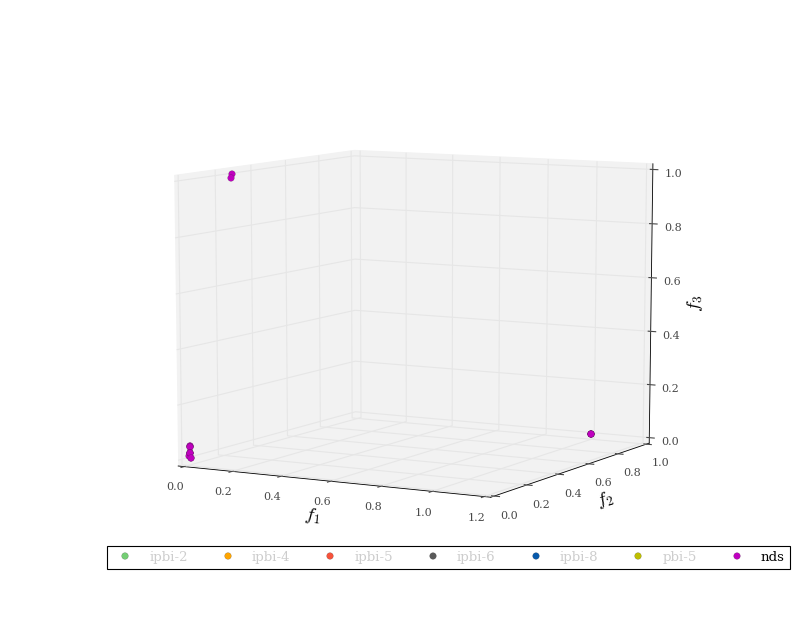

In [23]:
%matplotlib nbagg

load_rcparams((10, 8))


debug_labels = list(labels) + ["nds"]
debug_pops = list(new_pops) + [new_objs_nds]

plot_pops(debug_pops, debug_labels, ncol=7);

La figura anterior muestra las soluciones no dominadas de las seis poblaciones. Note que se encuentran en tres regiones dispersas, lo cual coincide con el mensaje 

```
The number of boxes where all solutions locate is 3
```

Es decir, no importa que PBI produzca más soluciones dentro del grid que las demas poblaciones, lo que importa a DCI es que se maximice la cobertura. En este caso, si una poblacion contiene soluciones dentro (o en el vecindario de ) los tres non-empty hyperboxes, entonces tendra la mejor cobertura. Dado esto, solo IPBI-5 cubre los tres hyperboxes, como se muestra en la figura anterior, de ahi que sea considerada como la mejor poblacion.

Algunas alternativas


| Opcion | Desventaja |
| ---------- | --------------------- |
| Usar CEDAS para incrementar el numero de soluciones no dominadas | Esto no funcionara porque, como se ve en la figura anterior, si se incrementa el numero de soluciones nds, estas solucioens estarian muy cerca del origen. Como resultado, no se crearian nuevos hyperboxes en donde PBI aporte soluciones.  |
| Usar CEDAS para reducir el numero de soluciones no dominadas| Esto tiene mas sentido, ya que, con algo de suerte, se podria usar CEDAS como metodo de eliminacion de soluciones Dominance Resistance Solutions. Con esto (1) tendriamos una mejor estimacion de z_nadir, (2) el grid seria mas ajustado al no considerar DRS, (3) la intuicion de DCI seria mejor, ya que se afectaria por las DRS |
| Normalizar antes de calcular DCI | `dci_norm` demostro que no basta con normalizar los objetivos para tener una buena estimacion de despempeno con DCI (y no sintonizar `divs` de paso). En su lugar, creo que la clave esta en remover los DRS |



Debemos probar lo siguiente:


```
# dci_norm_cedas
1*. Obtain non-dominated solutions
2*. Define z_ideal as z_nadir from non-dominated solutions
3*. Normalize populations using z_ideal and z_nadir
4. Compute grid dimensions (lb, ub, hs)
5. Filter solutions outside the grid
6. Identify non-empty hyperboxes from non-dominated solutions
8. Compute DCI
```













1. NDS en pops usando CEDAS

```
to_keep_cedas = cedas(pops, s=0.3)
objs_nds_cedas = merge_pops[to_keep_cedas]  # objetivos transformados
                                            # solo nos interesan los indices
```

2. Identify non-dominated solutions with no transformation

```
objs_nds = merge_pops[to_keep_cedas]        # este subconjunto debe estar libre de DRS
```

2. Estimar z_nadir con los indices identificados por cedas

```
z_nadir = objs_nds.max(axis=0)
```


3. Normalizar pops

...



dci en irregular fallo? debio de haber fallado porque no hace normalizacion!
crear un benchmark de prueba para validar metodos de contribucion
graficar los objetivos transformados











In [28]:
# cedas.py
from __future__ import print_function
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt

eps = 1.0e-20


def cedas_slow(objs, s):
    """
    Contraction and Expansion of Dominance Area of Solutions
    
    Input
    objs        (pop_size, m_objs) array of objectives
    s           double, cedas parameter
                s = 0.5 results in conventional Pareto dominance (ie, there is no transormation)
    
    Output
    objs_t      (pop_size, m_objs) array of 'relaxed' objectives
    """
    
    pop_size, m_objs = objs.shape
    objs_t = np.zeros((pop_size, m_objs))
    
    if isinstance(s, (int, float)):
        # convert it to an array
        # thus, there is a S_i value for each objective f_i
        s = np.array([ s for i in range(m_objs)])
    
    
    for i in range(pop_size):
        
        f   = objs[i]                   # (m_objs, ) array
        r   = norm(f)                   # scalar
        f_t = np.zeros((m_objs), )      # transformed array
        
        # adjust norm
        r_omega = r
        if r == 0:
            r_omega = eps
        
        for m in range(m_objs):
            
            fi = f[m]                       # i-th objective value
            omega = np.arccos(fi/r_omega)  
            phi = s[m]*np.pi                # adjust for i-th objective value
            
            sin_phi = np.sin(phi)
            
            # adjust sin(phi)
            if sin_phi == 0:
                sin_phi = eps
                
            # i-th obj transformation
            f_t[m] = (r*np.sin(omega + phi)) / sin_phi
        
        # save vector
        objs_t[i,:] = f_t.copy()
    
    return objs_t.copy()
    
    
# -- main --
    
objs = np.array([
            [8.0, 4.0],
            [3.0, 5.0],
            [4.0, 3.0]])

objs_1 = cedas_slow(objs, s=0.25)
objs_2 = cedas_slow(objs, s=0.50)
objs_3 = cedas_slow(objs, s=0.75)


import os, sys, argparse

np.seterr(all='raise')

# add lab's path to sys.path
lab_path = os.path.abspath("../../")
sys.path.insert(0, lab_path)

from rocket.plot import plot_pops

pops = (objs, objs_1, objs_2, objs_3)
labels = ("original", "0.25", "0.50", "0.75")
#plot_pops(pops, labels, loc="upper left")



In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import os, sys
from vfns import vfns
from dci import normalize_pops, normalize, filter_pop, filter_pops, get_grid_locs, get_grid_dims, get_contribution_degree

def dci_norm_cedas(pops, divs, s=0.4, procs=4, debug=False):
    """
    Compute the DCI indicator using normalization.
    
    Input
    pops        list of (pop_size, m_objs) objs matrices
    divs        int, number of divisions of the grid
    procs       int, number of processes for nds
    
    Output
    dci_vals    (n_pops, ) dci values
    """
    
    # 0. transform objs
    merged_objs_cedas = np.vstack(pops)
    objs_cedas = cedas_slow(merged_objs_cedas, s)
    
    
    
    
    # 1. get non-dominated solutions using transformed objs
    merged_pops = np.vstack(pops)
    fronts, ranks = vfns(objs_cedas, procs)
    best_front = np.array(fronts[0], dtype=int)
    objs_nds = merged_pops[best_front]        # keep the original objectives
    
    # debug
    if debug:
        print("The number of non-dominated solutions is %d" % objs_nds.shape[0]);
    
    # 2. obtain z_ideal, z_nadir from objs_nds
    z_ideal = objs_nds.min(axis=0)
    z_nadir = objs_nds.max(axis=0)
    
    # 3. normalize pops and objs_nds
    norm_pops = normalize_pops(pops, z_ideal, z_nadir)
    norm_objs_nds = normalize(objs_nds, z_ideal, z_nadir)
    
    # 4. compute grid dimesions
    m_objs = norm_objs_nds.shape[1]
    ref_ideal = np.zeros((m_objs, ))
    ref_nadir = np.ones((m_objs, ))
    lb, ub, hs = get_grid_dims(ref_ideal, ref_nadir, divs)
    
    # debug
    if debug:
        print("lb: %s" % vector_str(lb))
        print("ub: %s" % vector_str(ub))
        print("hs: %s" % vector_str(hs))
    
    # remove solutions out of the grid
    pops = filter_pops(norm_pops, lb, ub, debug)
    objs_nds = filter_pop(norm_objs_nds, lb, ub, debug)
    
    # get locations of pops in grid
    locs_pops = []
    
    for objs_pop in pops:
        
        # (pop_size, m_objs) int matrix, it contains the location of
        # the obj vectors in objs_pop within the grid
        locs_pop = get_grid_locs(objs_pop, lb, hs)
        
        # add it to the list
        locs_pops.append(locs_pop.copy())
    
    # get nds location
    locs_nds = get_grid_locs(objs_nds, lb, hs)
    
    # get nds hyperboxes
    # we use a dictionary for efficient lookup and deletion of duplicate rows in locs_nds
    hyperboxes = {}
    
    for hb_loc in locs_nds:
        
        # cast from np.array to tuple
        key = tuple(hb_loc)
        
        if not key in hyperboxes:
            
            # hyperboxes[loc] contains the number of solutions in the
            # hyperbox defined by loc (although this counter is not necessary for computing DCI)
            hyperboxes[key] = 1         
        
        else:
            
            # increment counter
            hyperboxes[key] += 1
            
            
    
    # compute contribution degree
    n_pops = len(locs_pops)
    n_hyperboxes = len(hyperboxes)
    
    # debug
    if debug:
        print("The number of boxes where all solutions locate is %d" % n_hyperboxes);
    
    cd_matrix = np.zeros((n_hyperboxes, n_pops))
    
    for row, hyperbox in enumerate(hyperboxes):
        
        for col, locs_pop in enumerate(locs_pops):
            
            # compute contribution degree
            cd_matrix[row, col] = get_contribution_degree(locs_pop, hyperbox)
            
            # debug
            #if debug:
            #    print("CD(P[%d], h=%s): %.4f" % (col, hyperbox, cd_matrix[row, col]))
            
        # debug
        #if debug:
        #    print("---")
        
    # compute dci
    by_col = 0
    dci_vals = cd_matrix.sum(axis=by_col) / n_hyperboxes
    
    return dci_vals.copy(), pops, objs_nds

In [3]:
# load objs
objs_a = load_objs("ipbi-2")
objs_b = load_objs("ipbi-4")
objs_c = load_objs("ipbi-5")
objs_d = load_objs("ipbi-6")
objs_e = load_objs("ipbi-8")
objs_f = load_objs("pbi-5")

# make a list of pops
pops = (objs_a, objs_b, objs_c, objs_d, objs_e, objs_f)
labels = ("ipbi-2", "ipbi-4", "ipbi-5", "ipbi-6", "ipbi-8", "pbi-5")

# get non-dominated solutions using vfns
merged_pops = np.vstack(pops)
fronts, ranks = vfns(merged_pops, procs=4)
best_front = np.array(fronts[0], dtype=int)
objs_nds = merged_pops[best_front]

# get reference vectors from non-dominated solutions
z_ideal = objs_nds.min(axis=0)
z_nadir = objs_nds.max(axis=0)

# print vectors
print("z_ideal:", vector_str(z_ideal))
print("z_nadir:", vector_str(z_nadir))

# compute dci
divs = 19
#dci_vals, new_pops, new_objs_nds = dci_norm_cedas(pops, divs, s=0.4, procs=4, debug=True)

dci_vals = dci_norm_cedas(pops, divs, s=0.4, procs=4, debug=True)


# print results
for i, val in enumerate(dci_vals):

    pop_label = labels[i]
    print("DCI(%s) \t= %.4f" % (pop_label, val))


z_ideal: 1.0906578799 2.1118154386 1.0546457250
z_nadir: 334.0560817797 334.6945123332 87.6318007555
The number of non-dominated solutions is 1
lb: 0.00000000 0.00000000 0.00000000
ub: 1.02631579 1.02631579 1.02631579
hs: 0.05401662 0.05401662 0.05401662
pop 0 has 0 in the grid (original size: 91)
pop 1 has 0 in the grid (original size: 91)
pop 2 has 0 in the grid (original size: 91)
pop 3 has 0 in the grid (original size: 91)
pop 4 has 0 in the grid (original size: 91)
pop 5 has 1 in the grid (original size: 91)
This pop has 1 in the grid (original size: 1)
The number of boxes where all solutions locate is 1


ValueError: zero-size array to reduction operation minimum which has no identity

In [37]:
dci_vals


(array([0.2 , 0.35, 0.  , 0.  , 0.  , 1.  ]),
 [array([[0.87999752, 0.92047693, 0.21731063],
         [0.4623915 , 0.45928421, 0.36366931],
         [0.75248345, 0.55999511, 0.51459351],
         [0.90812114, 0.52048297, 0.        ]]),
  array([[0.        , 1.        , 0.98131175]]),
  array([[0.4623915 , 0.45928421, 0.36366931],
         [0.94712812, 0.72681862, 0.67104017]]),
  array([[0.65827568, 0.42579741, 0.22293276],
         [0.75248345, 0.55999511, 0.51459351],
         [0.4623915 , 0.45928421, 0.36366931],
         [0.66427385, 0.52082202, 0.55690562]]),
  array([[0.87999752, 0.92047693, 0.21731063]]),
  array([[0.65827568, 0.42579741, 0.22293276],
         [0.94712812, 0.72681862, 0.67104017],
         [0.        , 1.        , 0.98131175],
         [0.01281231, 0.99328567, 0.96308319],
         [0.26400979, 0.62477003, 0.39075626],
         [0.34181612, 0.67555715, 0.44445451],
         [0.28856292, 0.6578319 , 0.41717282],
         [0.45990777, 0.65774534, 0.18835153],
    